## shape generator

## pixelize and save as pkl

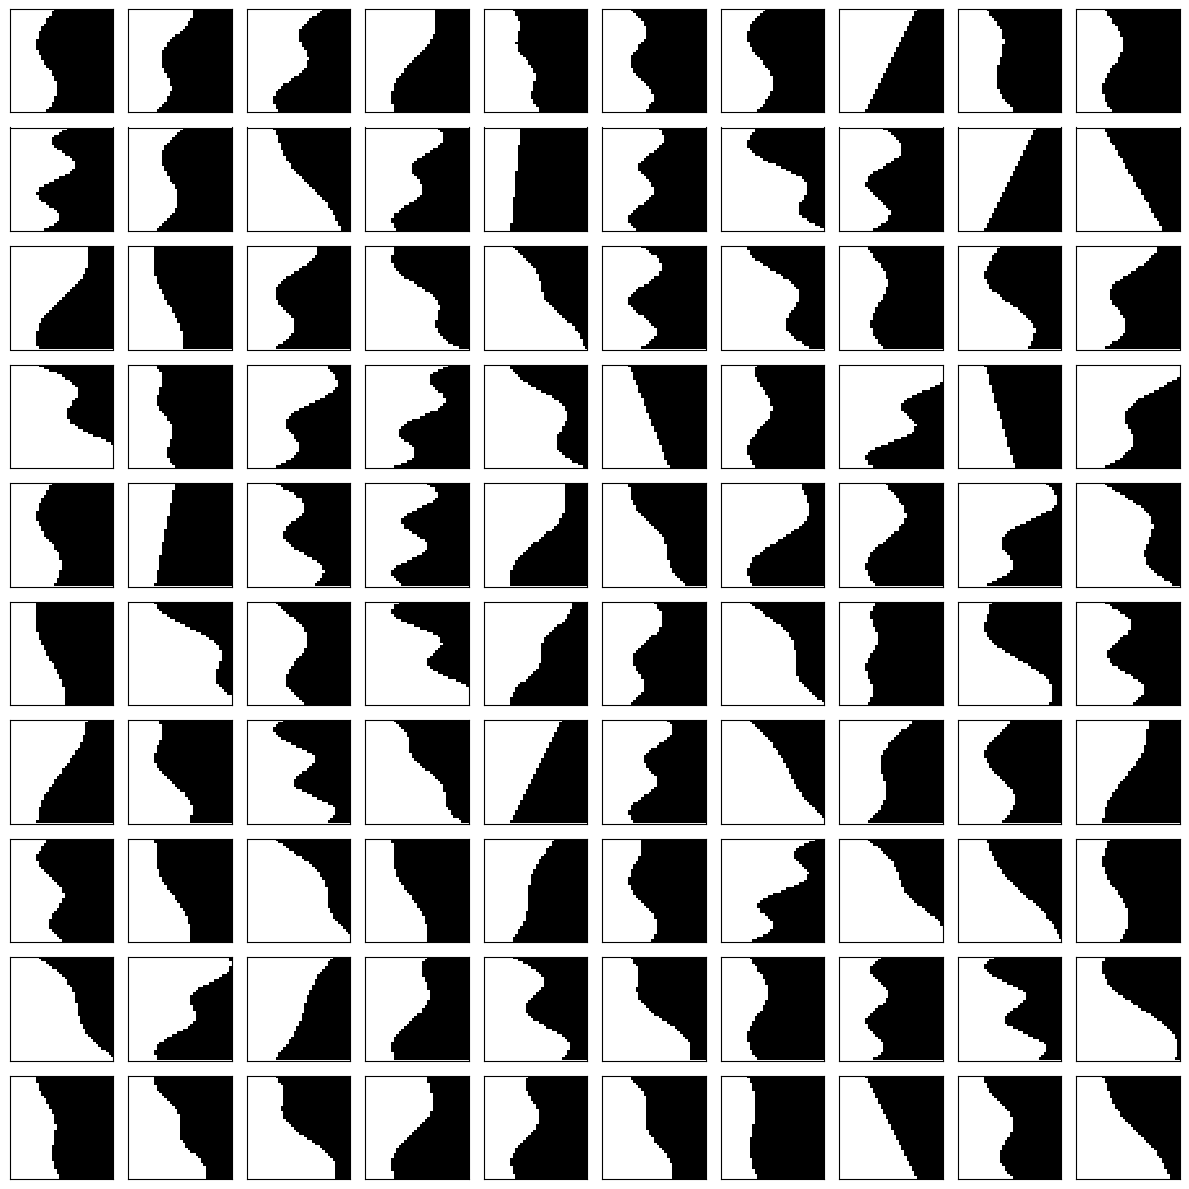

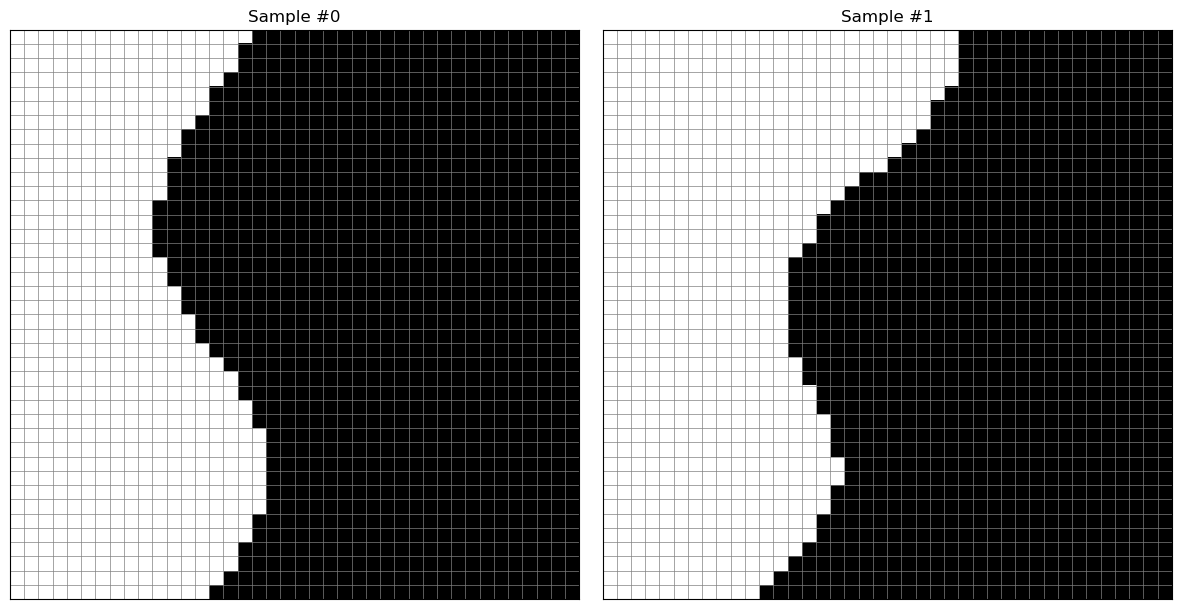

In [16]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

# parameters
grid_size  = 40       # cells per axis for batch matrices              
amplitudes = np.arange(-6, 7, 2)     # amplitudes: -4, -2, 0, 2, 4
periods    = np.arange(20, 41, 5)     # periods: 20, 25, 30, 35, 40
length     = 40                       # z range
n_points   = 1000                     # samples per curve
slopes     = np.arange(-0.8, 0.8, 0.1)  # slopes: -0.4 to 0.35
batch_size = 100       # number of samples in batch
y_offset = 10

# precompute x values
x = np.linspace(0, length, n_points)

def make_matrix_from_y(y_vals):
    """Rasterize y(x) into a grid_size×grid_size binary matrix."""
    m = np.zeros((grid_size, grid_size), dtype=int)
    for col in range(grid_size):
        x_val = (col + 0.5) * length / grid_size
        y_val = np.interp(x_val, x, y_vals)
        row = int(y_val / length * (grid_size - 1))
        row = np.clip(row, 0, grid_size - 1)
        m[:row+1, col] = 1
    return m

# sample function
def sample_sine_curve_matrix():
    """Generate random sine-based curve matrix."""
    A = random.choice(amplitudes)
    P = random.choice(periods)
    a = random.choice(slopes)
    y = A * np.sin(2 * np.pi * x / P) + a * x
    y += (y_offset - y.min())  # shift so min(y) == 5
    return make_matrix_from_y(y)

# 1) Plot 10×10 random curves
sine_matrices = [np.transpose(sample_sine_curve_matrix()) for _ in range(batch_size)]

fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for ax, mat in zip(axes.flat, sine_matrices):
    ax.imshow(mat, origin='lower', cmap='gray', interpolation='nearest')
    ax.set(xticks=[], yticks=[], frame_on=True)
    for sp in ax.spines.values(): sp.set_edgecolor('black')
    
plt.tight_layout()
plt.show()

# 2) Create batch, save and load via pickle, then display two samples with full cell grid
with open('batch_matrices.pkl', 'wb') as f:
    pickle.dump(sine_matrices, f)
with open('batch_matrices.pkl', 'rb') as f:
    loaded_batch = pickle.load(f)

indices = [0,1]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, idx in zip(axes, indices):
    mat = loaded_batch[idx]
    ax.imshow(mat, origin='lower', cmap='gray', interpolation='nearest')
    ax.set_title(f"Sample #{idx}")
    # enable grid below image
    ax.set_axisbelow(True)
    # minor ticks at each cell boundary
    ax.set_xticks(np.arange(-0.5, grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid_size, 1), minor=True)
    # remove tick labels
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    # draw grid lines on minor ticks
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

#------------------------# for abaqus compatibility #------------------------#
# Save the batch matrices in a format compatible with Python 2.7
import pickle

with open('batch_matrices.pkl', 'rb') as f:
    data = pickle.load(f)

with open('batch_matrices_py27.pkl', 'wb') as f:
    pickle.dump(data, f, protocol=2)


## toolpath generator

Generating toolpaths:   0%|          | 0/100 [00:00<?, ?it/s]

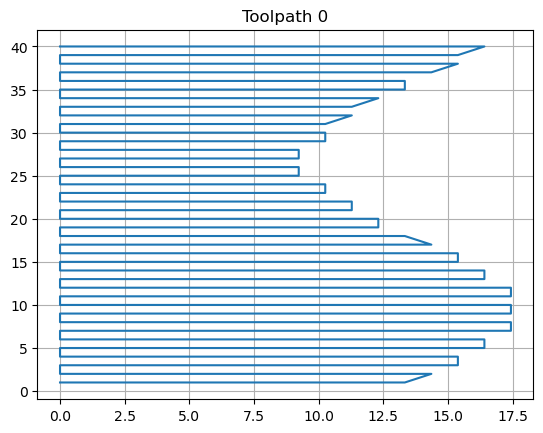

Generating toolpaths: 100%|██████████| 100/100 [00:00<00:00, 307.45it/s]


In [18]:
import pickle
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt  # plotting은 필요시 유지

# parameters
delta_x = 1
z_val = 0
a = 0.2  # time scaling factor

h = 40
grid_size = 40  # grid size for the binary matrices

# output directory
save_dir = "/home/ftk3187/github/GAMMA/GEOASNO_research/DED_GAMMA_solver/00_masking/toolpaths"
os.makedirs(save_dir, exist_ok=True)

# load binary matrices
with open('batch_matrices_py27.pkl', 'rb') as f:
    batch = pickle.load(f)

# function to extract curve from matrix
def matrix_to_curve(mat):
    px_per_step = int(delta_x / (h / grid_size))
    n_steps     = grid_size // px_per_step
    ys = []
    for k in range(n_steps):
        block = mat[k*px_per_step:(k+1)*px_per_step, :]
        cols = np.where(block.any(axis=0))[0]
        y_px = cols.max() if len(cols) else 0
        ys.append((y_px / (grid_size - 1)) * h)
    return ys

# process each matrix
for idx in tqdm(range(len(batch)), desc="Generating toolpaths"):
    ys = matrix_to_curve(batch[idx])
    n = len(ys)

    # build zig-zag points
    points = [(0.0, 0.0)]
    for i in range(0, n, 2):
        x0, x1, x2 = i*delta_x, (i+1)*delta_x, (i+2)*delta_x
        points += [
            (x0, ys[i]),       # up
            (x1, ys[i+1]),     # right on top
            (x1, 0.0)          # down
        ]
        if i + 2 < n:
            points.append((x2, 0.0))  # right on base

    # time values
    t_vals = [0.0]
    for (x0, y0), (x1, y1) in zip(points, points[1:]):
        dist = np.hypot(x1 - x0, y1 - y0)
        t_vals.append(t_vals[-1] + a * dist)

    # alternating flags: 0, 1, 0, ...
    flags = [i % 2 for i in range(len(points))]

    # create dataframe
    df = pd.DataFrame({
        't': t_vals,
        'x': [p[1] for p in points],
        'y': [p[0] +delta_x for p in points],
        'z': [z_val] * len(points),
        'flag': flags
    })

    # save to .crs (CSV format with .crs extension)
    fname = f"toolpath_{idx}.crs"
    save_path = os.path.join(save_dir, fname)
    with open(save_path, 'w') as f:
        for row in zip(df['t'], df['x'], df['z'], df['y'], df['flag']):
            f.write("{:8.4f}\t{:9.4f}\t{:9.4f}\t{:8.4f}\t{:d}\n".format(*row))

    # optional: plot one or a few
    if idx < 1:
        plt.figure()
        plt.plot(df['x'], df['y'])
        plt.title(f"Toolpath {idx}")
        plt.grid(True)
        plt.show()

## masking scene generator

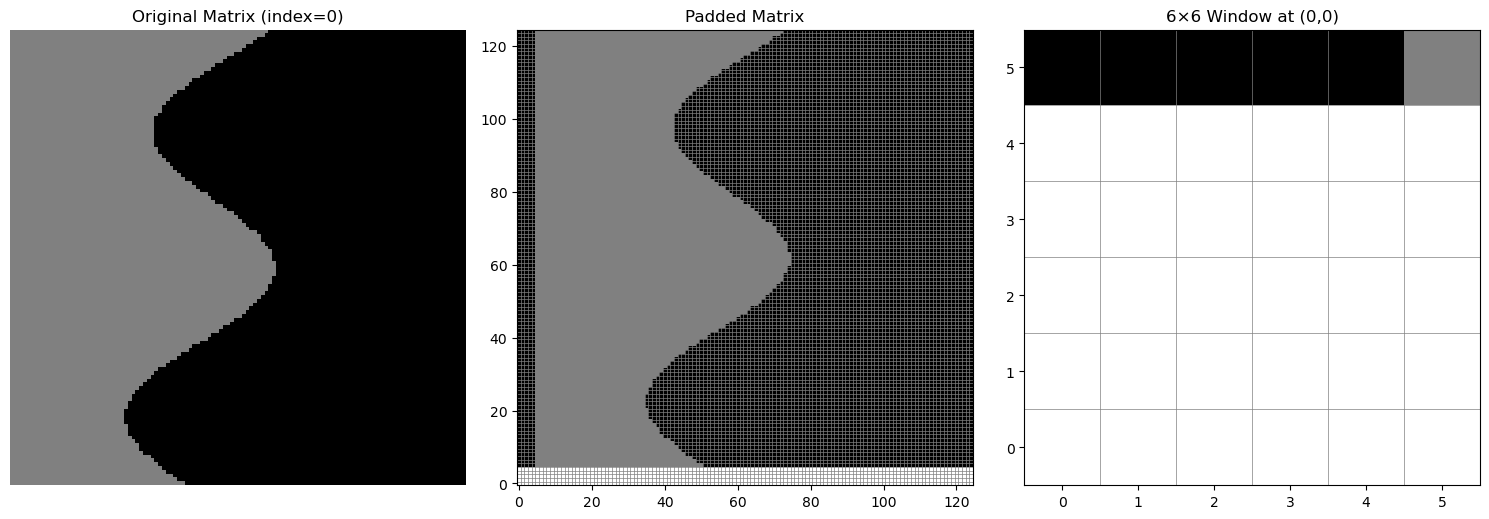

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# settings
batch_file = 'batch_matrices.pkl'  # pickle file path
window_size = 6                    # moving window dimension
pad_width = window_size - 1       # padding size for each side

# load batch matrix from pickle
with open(batch_file, 'rb') as f:
    batch = pickle.load(f)

mat = batch[0]

# pad function for handling boundaries
def pad_matrix(mat, pad):
    left = np.zeros((mat.shape[0], pad), dtype=int)
    mat_l = np.hstack([left, mat])
    bottom = np.full((pad, mat_l.shape[1]), 2, dtype=int)
    return np.vstack([bottom, mat_l])

# apply padding and extract window at original (0,0)
padded = pad_matrix(mat, pad_width)

# id_x, id_y = pad_width, pad_width  # shifted (0,0)
id_x, id_y = 0,0
window = padded[id_y:id_y+window_size, id_x:id_x+window_size]


# display padded matrix and extracted window with grid lines
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
cmap = ListedColormap(['black', 'gray', 'white'])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

# select one sample matrix and display
ax0.imshow(mat, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')
ax0.set_title('Original Matrix (index=0)')
ax0.axis('off')

# padded matrix plot
ax1.imshow(padded, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')
ax1.set_title('Padded Matrix')
# configure grid: show minor ticks only, hide labels
ax1.set_xticks(np.arange(-0.5, padded.shape[1], 1), minor=True)
ax1.set_yticks(np.arange(-0.5, padded.shape[0], 1), minor=True)
ax1.tick_params(axis='both', which='minor', length=0)
ax1.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

# window plot
ax2.imshow(window, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')
ax2.set_title(f'{window_size}×{window_size} Window at ({id_x},{id_y})')
# configure grid for window
ax2.set_xticks(np.arange(-0.5, window_size, 1), minor=True)
ax2.set_yticks(np.arange(-0.5, window_size, 1), minor=True)
ax2.tick_params(axis='both', which='minor', length=0)
ax2.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()
